In [1]:
from jaxgym.field import (
    schiske_lens_expansion_xyz,
    obtain_first_order_electrostatic_lens_properties,
)
import jaxgym.components as comp
from jaxgym.ray import Ray
from jaxgym.run import run_to_end

import jax
import jax.numpy as jnp
import tqdm

from scipy.constants import h as h_planck, e, m_e
import sympy as sp
import os

import matplotlib.pyplot as plt

import optax
from optax import apply_updates
from tqdm import trange
import equinox as eqx

jax.config.update("jax_platform_name", "gpu")
jax.config.update("jax_enable_x64", True)
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"


%matplotlib widget

/home/dl277493/JaxTemGym/src/jaxgym/ode.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


In [2]:
@eqx.filter_jit
def run_to_end_matrix_wrapper(ray_matrix):
    ray = Ray(
        x=ray_matrix[0],
        y=ray_matrix[1],
        dx=ray_matrix[2],
        dy=ray_matrix[3],
        z=jnp.array(PointSource.z, float),
        pathlength=0.0,
        _one=1.0,
    )

    ray = run_to_end(ray, model)

    ray_matrix_out = jnp.array([ray.x, ray.y, ray.dx, ray.dy]).T
    return ray_matrix_out, ray.pathlength


run_batch = jax.jit(jax.vmap(run_to_end_matrix_wrapper))


@eqx.filter_jit
def loss(tilts, positions, det_coords):
    tilts_x, tilts_y = tilts[:, 0], tilts[:, 1]
    positions_x, positions_y = positions[:, 0], positions[:, 1]

    ray_matrix = jnp.array([positions_x, positions_y, tilts_x, tilts_y]).T
    ray_matrix_out, _ = run_batch(ray_matrix)

    det_rays_x, det_rays_y, _, _ = ray_matrix_out.T

    rays_at_end = jnp.array([det_rays_x, det_rays_y]).T

    error = jnp.linalg.norm(rays_at_end - det_coords, axis=1)
    error = jnp.sum(error**2) / (det_coords.shape[0] * det_coords.shape[1])

    return error


@eqx.filter_jit
def lbfgs_step(tilts, opt_state):
    # compute current loss and grads
    loss_val, grads = jax.value_and_grad(lambda t: loss(t, cur_positions, det_coords))(
        tilts
    )
    updates, opt_state = lbfgs_solver.update(
        grads,
        opt_state,
        params=tilts,
        value=loss_val,
        grad=grads,
        value_fn=lambda t: loss(t, cur_positions, det_coords),
    )
    tilts = apply_updates(tilts, updates)
    return tilts, opt_state, loss_val


@eqx.filter_jit
def adam_step(tilts, opt_state):
    # compute current loss and grads
    loss_val, grads = jax.value_and_grad(lambda t: loss(t, cur_positions, det_coords))(
        tilts
    )
    # update with adamw
    updates, opt_state = adam_solver.update(grads, opt_state, params=tilts)
    tilts = apply_updates(tilts, updates)
    return tilts, opt_state, loss_val

In [3]:
X, Y, Z = sp.symbols("X Y Z")

scale = 1e6  # set to mm scale
# Set Parameters for Schiske Electrostatic Lens
# Define lens parameters

z_init = -0.015 * scale  # Convert m to um units
a = 0.0004 * scale  # Convert m to um units
phi_0 = 1000  # Volts

k = 0.4 ** (1 / 2)  # Unitless

(
    phi_expansion_symbolic,
    E_lambda,
    phi_lambda,
    phi_lambda_axial,
    phi_lambda_prime,
    phi_lambda_double_prime,
    phi_lambda_quadruple_prime,
    phi_lambda_sextuple_prime,
) = schiske_lens_expansion_xyz(X, Y, Z, phi_0, a, k)

wavelength = h_planck / (2 * abs(e) * m_e * phi_lambda_axial(z_init)) ** (1 / 2) * scale


z_pos, g, g_, h, h_, mag_real, z_image, z_focal_real, z_focal_asymp, z_pi = (
    obtain_first_order_electrostatic_lens_properties(
        z_init,
        phi_lambda_axial,
        phi_lambda_prime,
        phi_lambda_double_prime,
        z_sampling=1000,
    )
)

In [4]:
z_init = jnp.array(z_init, float)
z_image = jnp.array(z_image, float)

PointSource = comp.Plane(z=z_init)
ElectrostaticLens = comp.ODE(
    z=z_init, z_end=z_image, phi_lambda=phi_lambda, E_lambda=E_lambda
)
Detector = comp.Detector(
    z=z_image, det_pixel_size=(5e-9 * scale, 5e-9 * scale), det_shape=(128, 128)
)
model = [PointSource, ElectrostaticLens, Detector]

det_coords = Detector.get_coords()

In [5]:
sample_object = plt.imread(r"SilverFast_Resolution_Target_USAF_1951.png")[:, :, 0]
sample_object = sample_object[1:-1, 1:-1]  # Crop the image to remove borders
sample_shape = sample_object.shape

object_x = jnp.linspace(-1e-7 * scale, 1e-7 * scale, sample_shape[0])
object_y = jnp.linspace(-1e-7 * scale, 1e-7 * scale, sample_shape[1])
object_x, object_y = jnp.meshgrid(object_x, object_y)
object_x = object_x.ravel()
object_y = object_y.ravel()

x_det_shape, y_det_shape = Detector.det_shape


x_det = det_coords[:, 0].ravel()
y_det = det_coords[:, 1].ravel()

det_coords = Detector.get_coords()

tilts = jax.random.uniform(
    jax.random.PRNGKey(1), shape=(det_coords.shape[0], 2), minval=-1e-5, maxval=1e-5
)

cur_positions = jnp.zeros((tilts.shape[0], 2))

adam_solver = optax.adam(learning_rate=1e-3)
opt_state_fast = adam_solver.init(tilts)

history_fast = []
max_iters_fast = 200

pbar = trange(max_iters_fast, desc="Fast adam phase", leave=True)
for _ in pbar:
    tilts, opt_state_fast, loss_val = adam_step(tilts, opt_state_fast)

    history_fast.append(loss_val)
    pbar.set_postfix(loss=loss_val)
    if loss_val < 5e-5:
        break

lbfgs_solver = optax.lbfgs(memory_size=2)
opt_state_slow = lbfgs_solver.init(tilts)
history_slow = []
max_iters_slow = 100

pbar = trange(max_iters_slow, desc="Slow LBFGS phase", leave=True)
for _ in pbar:
    tilts, opt_state_slow, loss_val = lbfgs_step(tilts, opt_state_slow)
    history_slow.append(loss_val)
    pbar.set_postfix(loss=loss_val)
    if loss_val < 5e-6:
        break

history = history_fast + history_slow

results = {"History": history}

Fast adam phase:   0%|          | 0/200 [00:01<?, ?it/s]


ValueError: Reverse-mode differentiation does not work for lax.while_loop or lax.fori_loop with dynamic start/stop values. Try using lax.scan, or using fori_loop with static start/stop.

In [ ]:
plt.figure()
for name, hist in results.items():
    plt.plot(hist, label=name)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss vs Iteration")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_1873508/1372483815.py:65: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


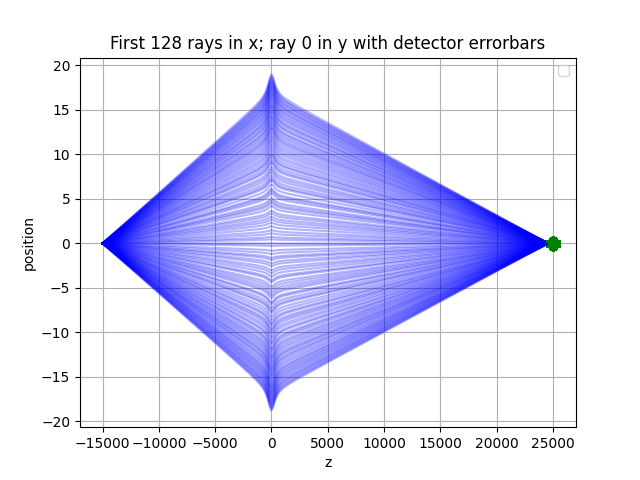

In [ ]:
import diffrax
from jaxgym.ode import electron_equation_of_motion

z_start = jnp.array(PointSource.z, float)
z_end = jnp.array(Detector.z, float)
u0 = phi_lambda(0.0, 0.0, z_start)

# prepare batched initial states [x, y, dx, dy, pathlength]
n_rays = tilts.shape[0]
y0s = jnp.concatenate([cur_positions, tilts, jnp.zeros((n_rays, 1))], axis=1)

# ODE solver setup
term = diffrax.ODETerm(electron_equation_of_motion)
solver = diffrax.Dopri8()
stepsize_controller = diffrax.PIDController(
    rtol=1e-10, atol=1e-10, dtmax=1e4, dtmin=1e-10
)
adjoint = diffrax.ForwardMode()


def integrate_one(y0):
    sol_end = diffrax.diffeqsolve(
        term,
        solver,
        t0=z_start,
        t1=z_end,
        y0=y0,
        dt0=None,
        stepsize_controller=stepsize_controller,
        args=(phi_lambda, E_lambda, u0),
        adjoint=adjoint,
        saveat=diffrax.SaveAt(t0=True, t1=True, steps=True),
    )
    return sol_end.ys, sol_end.ts


ys, zs = jax.vmap(integrate_one)(y0s)
pixel_width, pixel_height = Detector.det_pixel_size

plt.figure()
for i in range(128):
    mask = jnp.isfinite(zs[i])
    z_vals = zs[i][mask]
    x_vals = ys[i][mask, 0]
    plt.plot(z_vals, x_vals, color="blue", alpha=0.3)
    plt.errorbar(
        Detector.z,
        det_coords[i, 0],
        yerr=pixel_width / 2,
        fmt="o",
        color="g",
        capsize=5,
    )

mask0 = jnp.isfinite(zs[0])
z0 = zs[0][mask0]
y0 = ys[0][mask0, 1]

plt.xlabel("z")
plt.ylabel("position")
plt.title("First 128 rays in x; ray 0 in y with detector errorbars")
plt.legend()
plt.grid(True)
plt.show()